# Assignment 1 - Logan Bolton

This was an individual project and I did everything in it without a partner.

## GenAI Disclaimer

I used GPT-5 to help with the implementation of the exact code syntax that I needed. I came up with the overall structure and solution to the problems.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io 
from skimage import color as change

import cv2

from IPython.display import Image

# Task 1: Photometric Decoder

<Figure size 640x480 with 0 Axes>

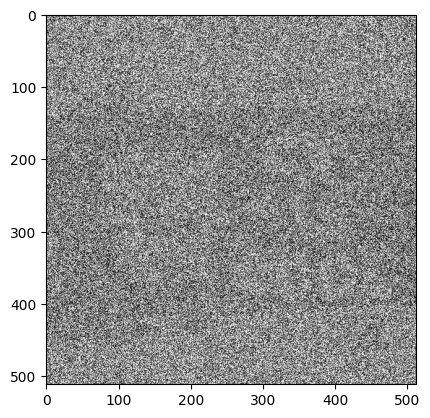

<Figure size 640x480 with 0 Axes>

In [106]:
photometric_path = "photometric_hidden_image.png"


img = cv2.imread(photometric_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

plt.imshow(img)
plt.figure()

In [128]:
def grayscale(image, weighted=True):
    if weighted:
        return (0.299 * image[:,:,0] + 
                 0.587 * image[:,:,1] + 
                 0.114 * image[:,:,2]).astype(np.uint8)
    else:
        return np.mean(image, axis=2).astype(np.uint8)

def brightness(image, brightness=0):
    return np.clip(image.astype(np.int16) + brightness, 0, 255).astype(np.uint8)

def contrast_stretch(image):
    if image.ndim == 2:
        ch = image.astype(np.float32)
        mn, mx = ch.min(), ch.max()
        if mx == mn:
            return np.zeros_like(image, dtype=np.uint8)
        return ((ch - mn) / (mx - mn) * 255).astype(np.uint8)

    stretched = np.zeros_like(image)
    for c in range(image.shape[2]):
        ch = image[:, :, c].astype(np.float32)
        mn, mx = ch.min(), ch.max()
        if mx == mn:
            stretched[:, :, c] = 0
        else:
            stretched[:, :, c] = ((ch - mn) / (mx - mn) * 255).astype(np.uint8)
    return stretched

def gamma_correction(image, gamma=1.0):
    x = image.astype(np.float32) / 255.0
    y = np.power(x, gamma)
    return np.clip(y * 255, 0, 255).astype(np.uint8)
    


(-0.5, 511.5, 511.5, -0.5)

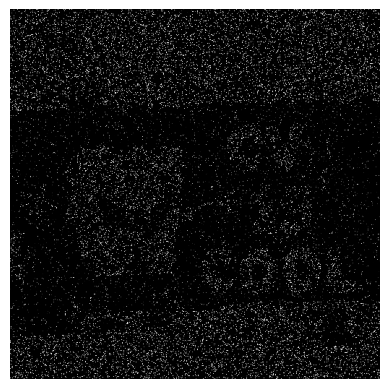

In [160]:
img = cv2.imread(photometric_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

img = gamma_correction(img, 35)
img = contrast_stretch(img)
img = grayscale(img, weighted=False)
img = brightness(img, -80)


plt.imshow(img, cmap='gray')
plt.axis('off')
# plt.figure()

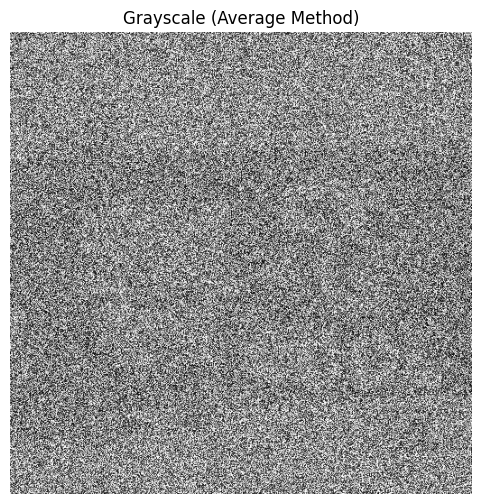

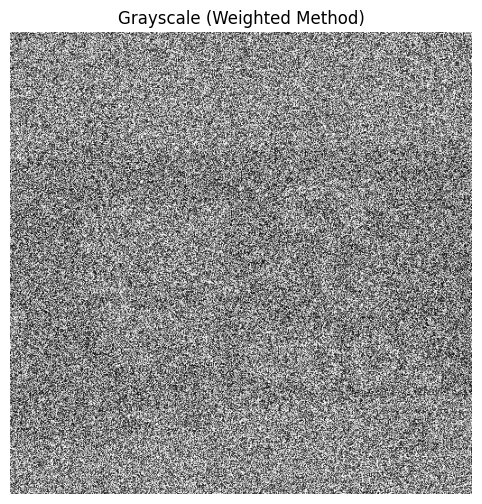

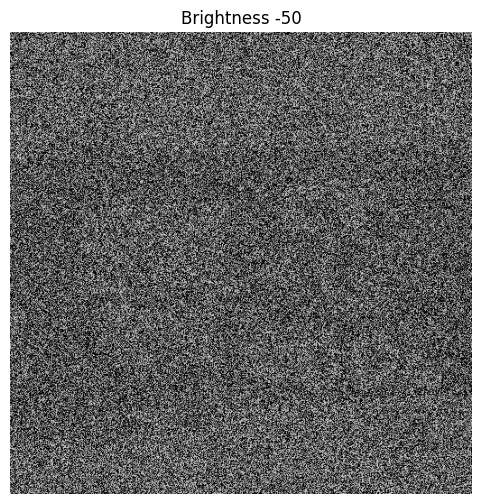

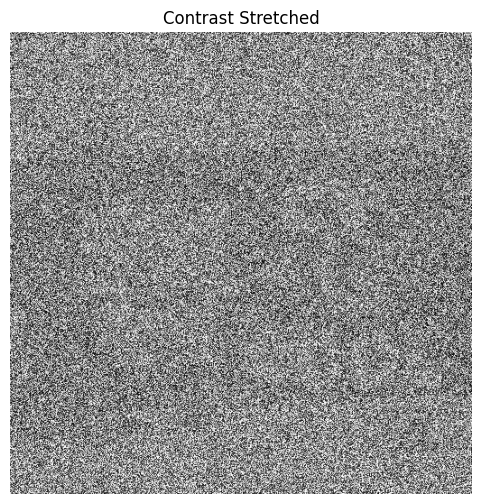

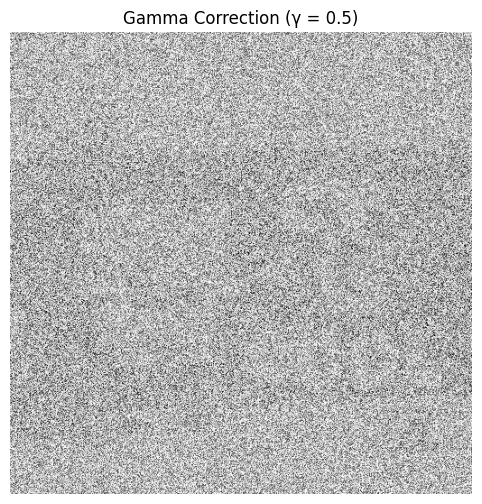

In [80]:
# ===== 2a. GRAYSCALE CONVERSION =====
# Method 1: Average grayscale
gray_average = np.mean(photometric_img, axis=2).astype(np.uint8)

plt.figure(figsize=(8, 6))
plt.imshow(gray_average, cmap='gray')
plt.title('Grayscale (Average Method)')
plt.axis('off')
plt.show()

# Method 2: Weighted grayscale (luminance formula: 0.299*R + 0.587*G + 0.114*B)
gray_weighted = (0.299 * photometric_img[:,:,0] + 
                 0.587 * photometric_img[:,:,1] + 
                 0.114 * photometric_img[:,:,2]).astype(np.uint8)

plt.figure(figsize=(8, 6))
plt.imshow(gray_weighted, cmap='gray')
plt.title('Grayscale (Weighted Method)')
plt.axis('off')
plt.show()

# ===== 2b. BRIGHTNESS ADJUSTMENT =====
brightness_decrease = -50
dark_img = np.clip(photometric_img.astype(np.int16) + brightness_decrease, 0, 255).astype(np.uint8)

plt.figure(figsize=(8, 6))
plt.imshow(dark_img)
plt.title(f'Brightness {brightness_decrease}')
plt.axis('off')
plt.show()

# ===== 2c. CONTRAST STRETCHING =====

# Linear contrast stretching - stretch values to use full 0-255 range
def contrast_stretch(image):
    # Work with each channel separately for color images
    stretched = np.zeros_like(image)
    for channel in range(image.shape[2]):
        ch = image[:,:,channel].astype(np.float32)
        min_val = ch.min()
        max_val = ch.max()
        # Stretch to 0-255 range
        stretched[:,:,channel] = ((ch - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return stretched

contrast_stretched = contrast_stretch(photometric_img)

plt.figure(figsize=(8, 6))
plt.imshow(contrast_stretched)
plt.title('Contrast Stretched')
plt.axis('off')
plt.show()

# Gamma correction with gamma > 1 (darkens bright areas)
gamma_dark = 0.5
gamma_corrected_dark = np.power(photometric_img / 255.0, gamma_dark) * 255
gamma_corrected_dark = gamma_corrected_dark.astype(np.uint8)

plt.figure(figsize=(8, 6))
plt.imshow(gamma_corrected_dark)
plt.title(f'Gamma Correction (γ = {gamma_dark})')
plt.axis('off')
plt.show()



# Task 2: Geometric Puzzle Solver

I originally tried to replicate the lecture code by handcrafting the matrix multiplication for each type of transformation at each step. This got out of hand super quickly and so I made methods for each type of transformation. I also discovered that cv2 has some super handle tools to do these types of transformations quickly, so I moved to that.

<Figure size 640x480 with 0 Axes>

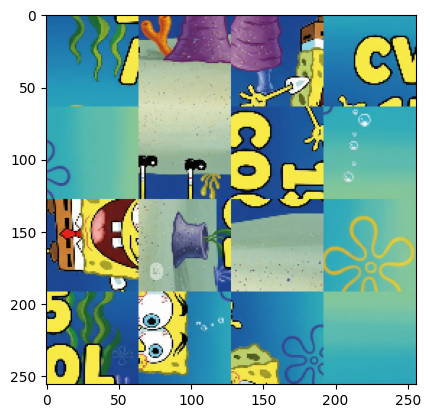

<Figure size 640x480 with 0 Axes>

In [ ]:
geometric_path = "geometric_puzzle_scrambled.png"

img = cv2.imread(geometric_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

plt.imshow(img)
plt.figure()

In [ ]:
def tile_slice(r, c, size=64):
    y0, x0 = r*size, c*size          # rows -> y, cols -> x
    return slice(y0, y0+size), slice(x0, x0+size)

def rotate_tile(img, tile, clockwise=True, size=64):
    r, c = tile
    ys, xs = tile_slice(r, c, size)
    patch = img[ys, xs]
    rot_flag = cv2.ROTATE_90_CLOCKWISE
    img[ys, xs] = cv2.rotate(patch, rot_flag)
    return img

def swap_tiles(img, tile1, tile2, size=64):
    r1, c1 = tile1
    r2, c2 = tile2
    ys1, xs1 = tile_slice(r1, c1, size)
    ys2, xs2 = tile_slice(r2, c2, size)

    tmp = img[ys1, xs1].copy() 
    img[ys1, xs1] = img[ys2, xs2]
    img[ys2, xs2] = tmp
    return img

def flip_horizontal(img, tile, size=64):
    r, c = tile
    ys, xs = tile_slice(r, c, size)
    img[ys, xs] = cv2.flip(img[ys, xs], 1)
    return img

def flip_vertical(img, tile, size=64):
    r, c = tile
    ys, xs = tile_slice(r, c, size)
    img[ys, xs] = cv2.flip(img[ys, xs], 0)
    return img
 

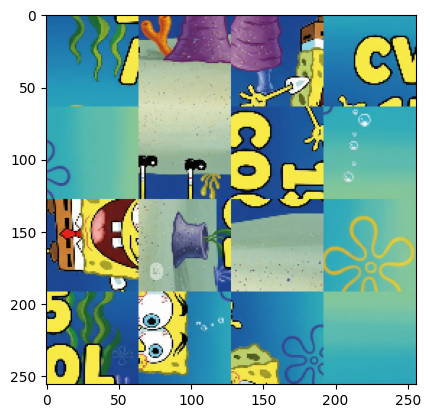

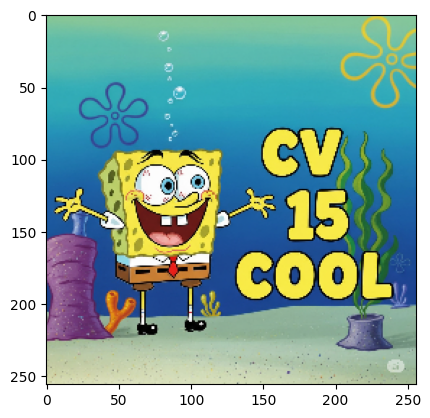

In [67]:
img = cv2.imread(geometric_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

# Original image
plt.imshow(img)
plt.figure()

# Rotate Image
img = rotate_tile(img, (0, 0))
img = rotate_tile(img, (0, 0))

img = rotate_tile(img, (0, 2))
img = rotate_tile(img, (0, 2))

img = rotate_tile(img, (1, 1))
img = rotate_tile(img, (1, 1))

img = rotate_tile(img, (1, 2))
img = rotate_tile(img, (1, 2))
img = rotate_tile(img, (1, 2))

img = rotate_tile(img, (2, 0))
img = rotate_tile(img, (2, 0))
img = rotate_tile(img, (2, 0))

img = rotate_tile(img, (2, 1))
img = rotate_tile(img, (2, 1))
img = rotate_tile(img, (2, 1))

img = rotate_tile(img, (3, 1))
img = rotate_tile(img, (3, 1))
img = rotate_tile(img, (3, 1))

img = rotate_tile(img, (3, 2))
img = rotate_tile(img, (3, 2))
img = rotate_tile(img, (3, 2))

# plt.imshow(img)
# plt.show()

# Rotate Tiles
img = swap_tiles(img, (1, 1), (3, 2))
img = swap_tiles(img, (1, 1), (0, 1))
img = swap_tiles(img, (3, 1), (0, 2))
img = swap_tiles(img, (2, 0), (1, 2))
img = swap_tiles(img, (2, 0), (1, 3))
img = swap_tiles(img, (3, 1), (1, 1))
img = swap_tiles(img, (3, 2), (2, 2))

img = swap_tiles(img, (0, 1), (0, 0))
img = swap_tiles(img, (0, 2), (0, 1))
img = swap_tiles(img, (0, 3), (0, 2))

img = swap_tiles(img, (1, 1), (1, 0))
img = swap_tiles(img, (1, 2), (1, 1))
img = swap_tiles(img, (1, 3), (1, 2))

img = swap_tiles(img, (1, 0), (2, 0))
img = swap_tiles(img, (0, 0), (1, 0))
img = swap_tiles(img, (0, 1), (1, 1))
img = swap_tiles(img, (0, 1), (2, 1))
img = swap_tiles(img, (1, 2), (2, 2))
img = swap_tiles(img, (0, 2), (1, 2))
img = swap_tiles(img, (0, 3), (1, 3))

img = swap_tiles(img, (3, 0), (2, 3))
img = swap_tiles(img, (0, 3), (0, 0))
img = swap_tiles(img, (3, 1), (3, 0))
img = swap_tiles(img, (0, 1), (3, 3))
img = swap_tiles(img, (0, 2), (3, 1))
img = swap_tiles(img, (0, 3), (0, 1))
img = swap_tiles(img, (0, 2), (0, 3))

# Flip Tiles & Polish

# plt.imshow(img)
# plt.show()

img = flip_vertical(img, (0, 0))
img = flip_horizontal(img, (0, 0))  
img = rotate_tile(img, (0, 0))

img = flip_vertical(img, (0, 1))  

img = flip_horizontal(img, (3, 0))
img = flip_horizontal(img, (2, 0))
img = flip_horizontal(img, (3, 1))

img = rotate_tile(img, (0, 3))
img = rotate_tile(img, (0, 3))
img = rotate_tile(img, (0, 3))

plt.imshow(img)
plt.show()
